In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
%matplotlib inline

# 定义文件全局变量
path = "/Users/skyamz/Desktop/JDD_Loan_Forecasting_Qualification/initdata/"

# 加载文件
file_order = pd.read_csv(path + "t_order.csv")
file_click = pd.read_csv(path + "t_click.csv")
file_user = pd.read_csv(path + "t_user.csv")
file_loan = pd.read_csv(path + "t_loan.csv")
file_loan_sum = pd.read_csv(path + "t_loan_sum.csv")

# 格式化时间
file_order['buy_time_format'] = pd.to_datetime(file_order['buy_time'])
file_loan['loan_time_format'] = pd.to_datetime(file_loan['loan_time'])

# 创建索引
file_order = file_order.set_index('buy_time_format')
file_loan = file_loan.set_index('loan_time_format')

#聚合用户订单月份数据
def user_order_month_aggregate(month):
    # 取月份数据
    file_order_month = file_order[month]
    # 重置索引
    file_order_month = file_order_month.reset_index()
    # 统计用户订单某个类目的价格、数量、折扣
    file_order_month_sum = file_order_month.groupby(['uid','cate_id'])['price','qty','discount'].sum()
    # 重置索引
    file_order_month_sum = file_order_month_sum.reset_index()
    # 合并2列
    file_order_month_sum['cate_id_and_count'] = file_order_month_sum['cate_id'].astype('str') + ':' +  file_order_month_sum['qty'].astype('str')
    # 统计用户下单类目
    file_order_month_sum_unique_cate_list = file_order_month_sum.groupby('uid')['cate_id_and_count'].unique()
    # 重置索引
    file_order_month_sum_unique_cate_list = file_order_month_sum_unique_cate_list.reset_index()
    # 统计用户订单全部价格、数量、折扣
    file_order_month_total = file_order_month.groupby(['uid'])['price','qty','discount'].sum()
    # 重置索引
    file_order_month_total = file_order_month_total.reset_index()
    # 将数据进行聚合操作
    user_order_month_aggregate = pd.merge(file_order_month_sum_unique_cate_list,file_order_month_total,how='outer',on='uid')
    return user_order_month_aggregate

# 索引各个月份数据
file_order_month_aggregate_11 = user_order_month_aggregate('2016-11')
file_order_month_aggregate_10 = user_order_month_aggregate('2016-10')
file_order_month_aggregate_09 = user_order_month_aggregate('2016-09')
file_order_month_aggregate_08 = user_order_month_aggregate('2016-08')

# 合并
file_click['pid_param'] = file_click['pid'].astype('str') +'_' + file_click['param'].astype('str')

# 用户点击统计
user_click_count = pd.DataFrame(file_click.groupby(['uid','pid_param'])['uid'].count())

# 重命名统计列
user_click_count.columns = ['click_count']

# 查询某个用户的点击统计
def user_click_count_serch(uid):
   user_click_count_serch = user_click_count.xs(uid, level='uid')
   return user_click_count_serch

# 查询某个参数的用户点击
def pid_and_param_click_count_serch(pid_param):
   pid_and_param_click_count_serch = user_click_count.xs(pid_param, level='pid_param')
   return pid_and_param_click_count_serch

# 查询用户的点击统计
# user_click_count_serch(1)

# 查询某个参数的用户点击
# pid_and_param_click_count_serch('8_1')

# 重置索引,并设置索引为uid
user_click_count_detail = user_click_count.reset_index().set_index('uid')

# 统计用户的总点击次数
user_click_count_total = pd.DataFrame(user_click_count.groupby('uid')['click_count'].sum())

# 重命名列名称
user_click_count_total.columns = ['click_count_total']

# 重置索引
user_click_count_total = user_click_count_total.reset_index()

# 合并2列为字典
user_click_count_detail['param_and_click'] = user_click_count_detail['pid_param'].astype('str') + ':' + user_click_count_detail['click_count'].astype('str')

# 合并分组
user_click_count_detail_aggregate = pd.DataFrame(user_click_count_detail.groupby('uid')['param_and_click'].unique())

# 重置索引
user_click_count_detail_aggregate = user_click_count_detail_aggregate.reset_index()

# 用户点击聚合
user_click_count_aggregate = pd.merge(user_click_count_detail_aggregate,user_click_count_total,how='outer',on='uid')

# 各月用户点击和订单数据汇总
user_click_count_and_order_month_aggregate_08 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_08,how='outer',on='uid')
user_click_count_and_order_month_aggregate_09 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_09,how='outer',on='uid')
user_click_count_and_order_month_aggregate_10 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_10,how='outer',on='uid')
user_click_count_and_order_month_aggregate_11 = pd.merge(user_click_count_detail_aggregate,file_order_month_aggregate_11,how='outer',on='uid')

# 重置索引
user_click_count_detail = user_click_count_detail.reset_index()

# 统计用户最大点击
user_click_count_detail_max = user_click_count_detail.loc[user_click_count_detail.groupby(['uid'])['click_count'].idxmax()].sort_values(by='uid')

# 查询每月订单最大数量
def file_order_month_max(month):
    file_order_month_sum = file_order[month].reset_index().groupby(['uid','cate_id'])['price','qty','discount'].sum().reset_index()
    file_order_month_sum.loc[file_order_month_sum.groupby(['uid'])['qty'].idxmax()].sort_values(by='uid')
    file_order_month_sum_max = file_order_month_sum.loc[file_order_month_sum.groupby(['uid'])['qty'].idxmax()].sort_values(by='uid')
    file_order_month_sum_max.columns = ['uid','cate_id_by_max_qty','price_by_max_qty','qty_max','discount_by_max_qty']
    return file_order_month_sum_max

# 查询点击最多次数和购买数量最大
def click_count_max_and_order_qty_max(month):
    click_count_max_and_order_qty_max = pd.merge(user_click_count_detail_max,file_order_month_max(month),how='outer',on='uid')
    click_count_max_and_order_qty_max = pd.merge(click_count_max_and_order_qty_max,file_user,how='outer',on='uid')
    return click_count_max_and_order_qty_max

# 统计贷款笔数
def loan_count(month):
    
    file_loan_count = pd.DataFrame(file_loan[month].groupby('uid')['uid'].count())
    file_loan_count.columns = ['loan_count']
    file_loan_count = file_loan_count.reset_index()
    file_loan_sum = pd.DataFrame(file_loan[month].groupby(['uid'])['loan_amount'].sum())
    file_loan_sum.columns = ['loan_sum']
    file_loan_sum = file_loan_sum.reset_index()
    file_loan_count_and_sum = pd.merge(file_loan_count,file_loan_sum,how='outer',on='uid')
    file_loan_count_and_sum['loan_sum_mean'] = file_loan_count_and_sum['loan_sum']/file_loan_count_and_sum['loan_count']
    return file_loan_count_and_sum

#打标用户当月是否借贷
def is_month_loan_user(month):
    loan_month = file_loan[month]
    is_loan_user = loan_month['uid'].unique()
    is_loan_user = pd.DataFrame(Series(is_loan_user))
    is_loan_user.columns = ['uid']
    is_loan_user['is_loan'] = 1
    return is_loan_user

#构建每个月的用户特征
def feature_month_uid(month,prefix_name):
    click_count_max_and_order_qty_max_tmp = click_count_max_and_order_qty_max(month)
    loan_count_tmp = loan_count(month)
    feature_month_uid = pd.merge(click_count_max_and_order_qty_max_tmp,loan_count_tmp,how='outer',on='uid')
    is_month_loan_user_tmp = is_month_loan_user(month)
    feature_month_uid = pd.merge(feature_month_uid,is_month_loan_user_tmp,how='outer',on='uid')
    feature_month_uid['diff'] = feature_month_uid['limit'] - feature_month_uid['loan_sum_mean']
    
    feature_month_uid.columns = [col+prefix_name for col in feature_month_uid.columns.values.astype('str')]
    feature_month_uid = feature_month_uid.rename(columns={"uid"+prefix_name:"uid"})
    return feature_month_uid

In [ ]:
#构建每个月的用户特征
def feature_month_uid(month,prefix_name):
    click_count_max_and_order_qty_max_tmp = click_count_max_and_order_qty_max(month)
    loan_count_tmp = loan_count(month)
    feature_month_uid = pd.merge(click_count_max_and_order_qty_max_tmp,loan_count_tmp,how='outer',on='uid')
    is_month_loan_user_tmp = is_month_loan_user(month)
    feature_month_uid = pd.merge(feature_month_uid,is_month_loan_user_tmp,how='outer',on='uid')
    feature_month_uid['diff'] = feature_month_uid['limit'] - feature_month_uid['loan_sum_mean']
    one_hot_pid_param = pd.get_dummies(feature_month_uid['pid_param'])
    one_hot_cate_id_by_max_qty = pd.get_dummies(feature_month_uid['cate_id_by_max_qty'])
    one_hot_pid_param['uid'] = feature_month_uid['uid']
    one_hot_cate_id_by_max_qty['uid'] = feature_month_uid['uid']
    one_hot_all = pd.merge(one_hot_pid_param,one_hot_cate_id_by_max_qty,how = 'outer',on='uid')
    feature_month_uid = pd.merge(feature_month_uid,one_hot_all,how='outer',on='uid')
    
    del feature_month_uid['param_and_click']
    del feature_month_uid['pid_param']
    del feature_month_uid['cate_id_by_max_qty']
    feature_month_uid.columns = [col+prefix_name for col in feature_month_uid.columns.values.astype('str')]
    feature_month_uid = feature_month_uid.rename(columns={"uid"+prefix_name:"uid"})
    return feature_month_uid

In [50]:
feature_month_uid_8 = feature_month_uid('2016-08','_8')
feature_month_uid_9 = feature_month_uid('2016-09','_9')
feature_month_uid_10 = feature_month_uid('2016-10','_10')
feature_month_uid_11 = feature_month_uid('2016-11','_11')

In [51]:
feature_month_uid_8_9 = pd.merge(feature_month_uid_8,feature_month_uid_9,how='outer',on='uid')
feature_month_uid_10_11 = pd.merge(feature_month_uid_10,feature_month_uid_11,how='outer',on='uid')
feature_month_uid_all = pd.merge(feature_month_uid_8_9,feature_month_uid_10_11,how='outer',on='uid')

In [53]:
del feature_month_uid_all['param_and_click_8']
del feature_month_uid_all['param_and_click_9']
del feature_month_uid_all['param_and_click_10']
del feature_month_uid_all['param_and_click_11']

In [54]:
feature_month_uid_all

,uid,pid_param_8,click_count_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,active_date_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,1,8_1,66.0,22.0,73.158573,22.0,18.936605,35,1,2016-04-27,...,6.536894,35,1,2016-04-27,5.974677,NaN,NaN,NaN,NaN,NaN
1,4,10_16,50.0,22.0,14.665733,4.0,11.159862,30,1,2016-03-26,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
2,5,8_1,7.0,1.0,52.248393,36.0,24.480130,30,2,2015-12-08,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
3,6,10_28,112.0,36.0,11.949272,4.0,2.554230,25,1,2016-04-13,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
4,7,10_16,33.0,NaN,NaN,NaN,NaN,30,1,2016-02-06,...,NaN,30,1,2016-02-06,6.153414,NaN,NaN,NaN,NaN,NaN
5,8,10_16,81.0,1.0,43.810418,42.0,8.127342,35,1,2016-04-15,...,0.000000,35,1,2016-04-15,6.153414,NaN,NaN,NaN,NaN,NaN
6,9,10_28,5.0,26.0,11.585922,3.0,0.000000,40,1,2015-12-27,...,2.419391,40,1,2015-12-27,6.292055,NaN,NaN,NaN,NaN,NaN
7,11,8_1,7.0,9.0,9.054182,4.0,2.554230,25,1,2016-06-28,...,0.000000,25,1,2016-06-28,6.292055,NaN,NaN,NaN,NaN,NaN
8,14,10_16,67.0,26.0,2.866920,1.0,0.000000,30,1,2016-01-28,...,0.000000,30,1,2016-01-28,5.974677,NaN,NaN,NaN,NaN,NaN
9,16,6_5,14.0,14.0,10.476114,4.0,4.383337,30,1,2016-06-15,...,4.047819,30,1,2016-06-15,5.974677,NaN,NaN,NaN,NaN,NaN


In [6]:
feature_month_uid_all_replace_none = feature_month_uid_all

In [ ]:
feature_month_uid_all_replace_none = feature_month_uid_all.where(feature_month_uid_all.notnull(), 0)

In [7]:
feature_month_uid_all_replace_none.columns.values

array(['uid', 'pid_param_8', 'click_count_8', 'param_and_click_8',
       'cate_id_by_max_qty_8', 'price_by_max_qty_8', 'qty_max_8',
       'discount_by_max_qty_8', 'age_8', 'sex_8', 'active_date_8',
       'limit_8', 'loan_count_8', 'loan_sum_8', 'loan_sum_mean_8',
       'is_loan_8', 'diff_8', 'pid_param_9', 'click_count_9',
       'param_and_click_9', 'cate_id_by_max_qty_9', 'price_by_max_qty_9',
       'qty_max_9', 'discount_by_max_qty_9', 'age_9', 'sex_9',
       'active_date_9', 'limit_9', 'loan_count_9', 'loan_sum_9',
       'loan_sum_mean_9', 'is_loan_9', 'diff_9', 'pid_param_10',
       'click_count_10', 'param_and_click_10', 'cate_id_by_max_qty_10',
       'price_by_max_qty_10', 'qty_max_10', 'discount_by_max_qty_10',
       'age_10', 'sex_10', 'active_date_10', 'limit_10', 'loan_count_10',
       'loan_sum_10', 'loan_sum_mean_10', 'is_loan_10', 'diff_10',
       'pid_param_11', 'click_count_11', 'param_and_click_11',
       'cate_id_by_max_qty_11', 'price_by_max_qty_11', 'qt

In [22]:
feature_month_uid_all_replace_none = feature_month_uid_all_replace_none.sort_values(by='uid')

In [23]:
feature_month_uid_all_replace_none

,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,1,8_1,66.0,8_1:66,22.0,73.158573,22.0,18.936605,35,1,...,6.536894,35,1,2016-04-27,5.974677,NaN,NaN,NaN,NaN,NaN
78439,2,NaN,NaN,NaN,3.0,9.472811,6.0,4.491791,40,1,...,4.623552,40,1,2016-03-30,6.153414,NaN,NaN,NaN,NaN,NaN
78440,3,NaN,NaN,NaN,44.0,31.280407,8.0,13.820537,30,2,...,3.437597,30,2,2016-05-08,6.292055,NaN,NaN,NaN,NaN,NaN
1,4,10_16,50.0,10_16:50,22.0,14.665733,4.0,11.159862,30,1,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
2,5,8_1,7.0,8_1:7,1.0,52.248393,36.0,24.480130,30,2,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
3,6,10_28,112.0,10_28:112,36.0,11.949272,4.0,2.554230,25,1,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
4,7,10_16,33.0,10_16:33,NaN,NaN,NaN,NaN,30,1,...,NaN,30,1,2016-02-06,6.153414,NaN,NaN,NaN,NaN,NaN
5,8,10_16,81.0,10_16:81,1.0,43.810418,42.0,8.127342,35,1,...,0.000000,35,1,2016-04-15,6.153414,NaN,NaN,NaN,NaN,NaN
6,9,10_28,5.0,10_28:5,26.0,11.585922,3.0,0.000000,40,1,...,2.419391,40,1,2015-12-27,6.292055,NaN,NaN,NaN,NaN,NaN
78441,10,NaN,NaN,NaN,10.0,29.252775,9.0,9.680118,30,1,...,4.446189,30,1,2016-02-13,5.292154,NaN,NaN,NaN,NaN,NaN


In [24]:
train_feature_month_uid_all_replace_none = feature_month_uid_all_replace_none[:int(len(feature_month_uid_all_replace_none['uid'])*0.8)]

In [25]:
train_feature_month_uid_all_replace_none

,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,1,8_1,66.0,8_1:66,22.0,73.158573,22.0,18.936605,35,1,...,6.536894,35,1,2016-04-27,5.974677,NaN,NaN,NaN,NaN,NaN
78439,2,NaN,NaN,NaN,3.0,9.472811,6.0,4.491791,40,1,...,4.623552,40,1,2016-03-30,6.153414,NaN,NaN,NaN,NaN,NaN
78440,3,NaN,NaN,NaN,44.0,31.280407,8.0,13.820537,30,2,...,3.437597,30,2,2016-05-08,6.292055,NaN,NaN,NaN,NaN,NaN
1,4,10_16,50.0,10_16:50,22.0,14.665733,4.0,11.159862,30,1,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
2,5,8_1,7.0,8_1:7,1.0,52.248393,36.0,24.480130,30,2,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
3,6,10_28,112.0,10_28:112,36.0,11.949272,4.0,2.554230,25,1,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
4,7,10_16,33.0,10_16:33,NaN,NaN,NaN,NaN,30,1,...,NaN,30,1,2016-02-06,6.153414,NaN,NaN,NaN,NaN,NaN
5,8,10_16,81.0,10_16:81,1.0,43.810418,42.0,8.127342,35,1,...,0.000000,35,1,2016-04-15,6.153414,NaN,NaN,NaN,NaN,NaN
6,9,10_28,5.0,10_28:5,26.0,11.585922,3.0,0.000000,40,1,...,2.419391,40,1,2015-12-27,6.292055,NaN,NaN,NaN,NaN,NaN
78441,10,NaN,NaN,NaN,10.0,29.252775,9.0,9.680118,30,1,...,4.446189,30,1,2016-02-13,5.292154,NaN,NaN,NaN,NaN,NaN


In [26]:
loan_and_user = pd.merge(file_loan_sum,file_user,how='outer',on='uid')
loan_and_user = loan_and_user.sort_values(by='uid')
del loan_and_user['age']
del loan_and_user['sex']
del loan_and_user['active_date']
del loan_and_user['limit']
train_Label = loan_and_user[:int(len(loan_and_user['uid'])*0.8)]

In [27]:
train_Label

,uid,loan_sum
65591,1,NaN
62373,2,NaN
56003,3,NaN
4862,4,4.723017
1123,5,6.584075
5438,6,6.266691
63568,7,NaN
30004,8,NaN
32838,9,NaN
50504,10,NaN


In [37]:
test_feature_month_uid_all_replace_none = feature_month_uid_all_replace_none[int(len(feature_month_uid_all_replace_none['uid'])*0.8):]

In [45]:
test_feature_month_uid_all_replace_none = test_feature_month_uid_all_replace_none.where(feature_month_uid_all.notnull(), 0)

In [47]:
test_feature_month_uid_all_replace_none.to_csv('test_feature_month_uid_all_replace_none.csv')

In [46]:
test_feature_month_uid_all_replace_none

,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,sex_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
86682,72795,0,0.0,0,1.0,55.311260,35.0,11.838162,30,2,...,0.000000,30,2,2016-03-06,6.292055,0.0,0.000000,0.000000,0.0,0.000000
86683,72796,0,0.0,0,26.0,5.186174,6202.0,0.000000,35,1,...,0.000000,35,1,2016-04-22,6.292055,0.0,0.000000,0.000000,0.0,0.000000
86684,72797,0,0.0,0,1.0,19.359469,10.0,9.463587,30,1,...,4.227255,30,1,2015-12-23,5.974677,0.0,0.000000,0.000000,0.0,0.000000
62733,72798,1_19,146.0,1_19:146,44.0,35.229981,15.0,15.365618,35,1,...,12.185387,35,1,2015-12-17,5.974677,1.0,6.212631,6.212631,1.0,-0.237953
62734,72799,10_16,19.0,10_16:19,25.0,45.563812,37.0,11.733474,30,1,...,1.478495,30,1,2016-05-24,5.722768,1.0,5.722768,5.722768,1.0,0.000000
62735,72800,8_1,42.0,8_1:42,22.0,15.957040,9.0,4.560311,40,1,...,0.000000,40,1,2016-03-16,5.292154,0.0,0.000000,0.000000,0.0,0.000000
62736,72801,8_1,2.0,8_1:2,33.0,4.048738,2.0,1.378869,30,2,...,3.245308,30,2,2016-05-20,6.292055,1.0,5.885770,5.885770,1.0,0.406284
62737,72802,8_1,58.0,8_1:58,26.0,16.340734,6.0,0.000000,35,1,...,0.000000,35,1,2016-05-04,5.974677,1.0,5.722768,5.722768,1.0,0.251909
62738,72803,9_1,8.0,9_1:8,22.0,8.856763,3.0,3.808193,30,1,...,1.891668,30,1,2015-12-29,5.722768,9.0,38.568461,4.285385,1.0,1.437384
62739,72804,10_16,3.0,10_16:3,0.0,0.000000,0.0,0.000000,30,1,...,0.000000,30,1,2016-03-20,5.722768,0.0,0.000000,0.000000,0.0,0.000000


In [30]:
feature_month_uid_all_replace_none_NAN_no_one_hot = pd.merge(train_feature_month_uid_all_replace_none , train_Label,how='outer',on='uid')

In [34]:
cols = list(feature_month_uid_all_replace_none_NAN_no_one_hot)
cols.insert(0, cols.pop(cols.index('loan_sum')))
feature_month_uid_all_replace_none_NAN_no_one_hot = feature_month_uid_all_replace_none_NAN_no_one_hot.loc[feature_month_uid_all_replace_none_NAN_no_one_hot.index[:], cols]
feature_month_uid_all_replace_none_NAN_no_one_hot

,loan_sum,uid,pid_param_8,click_count_8,param_and_click_8,cate_id_by_max_qty_8,price_by_max_qty_8,qty_max_8,discount_by_max_qty_8,age_8,...,discount_by_max_qty_11,age_11,sex_11,active_date_11,limit_11,loan_count_11,loan_sum_11,loan_sum_mean_11,is_loan_11,diff_11
0,NaN,1,8_1,66.0,8_1:66,22.0,73.158573,22.0,18.936605,35,...,6.536894,35,1,2016-04-27,5.974677,NaN,NaN,NaN,NaN,NaN
1,NaN,2,NaN,NaN,NaN,3.0,9.472811,6.0,4.491791,40,...,4.623552,40,1,2016-03-30,6.153414,NaN,NaN,NaN,NaN,NaN
2,NaN,3,NaN,NaN,NaN,44.0,31.280407,8.0,13.820537,30,...,3.437597,30,2,2016-05-08,6.292055,NaN,NaN,NaN,NaN,NaN
3,4.723017,4,10_16,50.0,10_16:50,22.0,14.665733,4.0,11.159862,30,...,0.000000,30,1,2016-03-26,5.292154,1.0,4.723017,4.723017,1.0,0.569137
4,6.584075,5,8_1,7.0,8_1:7,1.0,52.248393,36.0,24.480130,30,...,21.030112,30,2,2015-12-08,6.292055,1.0,6.584075,6.584075,1.0,-0.292020
5,6.266691,6,10_28,112.0,10_28:112,36.0,11.949272,4.0,2.554230,25,...,13.759507,25,1,2016-04-13,6.292055,1.0,6.266691,6.266691,1.0,0.025363
6,NaN,7,10_16,33.0,10_16:33,NaN,NaN,NaN,NaN,30,...,NaN,30,1,2016-02-06,6.153414,NaN,NaN,NaN,NaN,NaN
7,NaN,8,10_16,81.0,10_16:81,1.0,43.810418,42.0,8.127342,35,...,0.000000,35,1,2016-04-15,6.153414,NaN,NaN,NaN,NaN,NaN
8,NaN,9,10_28,5.0,10_28:5,26.0,11.585922,3.0,0.000000,40,...,2.419391,40,1,2015-12-27,6.292055,NaN,NaN,NaN,NaN,NaN
9,NaN,10,NaN,NaN,NaN,10.0,29.252775,9.0,9.680118,30,...,4.446189,30,1,2016-02-13,5.292154,NaN,NaN,NaN,NaN,NaN


In [35]:
feature_month_uid_all_replace_none_NAN_no_one_hot.to_csv('feature_month_uid_all_replace_none(NAN_no_one_hot).csv')

In [109]:
import xgboost as xgb
from svmutil import *

In [160]:
train_df = feature_month_uid_all_replace_none[:int(len(feature_month_uid_all_replace_none['uid'])*0.8)]

In [161]:
train_df.shape

(72794, 565)

In [162]:
test_df = feature_month_uid_all_replace_none[int(len(feature_month_uid_all_replace_none['uid'])*0.8)+1:]

In [163]:
loan_and_user = pd.merge(file_loan_sum,file_user,how='outer',on='uid')

In [164]:
loan_and_user = loan_and_user.sort_values(by='uid')

In [165]:
del loan_and_user['age']
del loan_and_user['sex']
del loan_and_user['active_date']
del loan_and_user['limit']
loan_and_user = loan_and_user.reset_index()

In [166]:
del loan_and_user['index']
del loan_and_user['uid']

In [167]:
loan_and_user = loan_and_user.where(loan_and_user.notnull(), 0)

In [168]:
loan_and_user

,loan_sum
0,0.000000
1,0.000000
2,0.000000
3,4.723017
4,6.584075
5,6.266691
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [169]:
train_Y = loan_and_user[:int(len(loan_and_user['loan_sum'])*0.8)]

In [170]:
train_Y.shape

(72794, 1)

In [171]:
test_Y = loan_and_user[int(len(loan_and_user['loan_sum'])*0.8)+1:]

In [172]:
test_Y.shape

(18198, 1)

In [173]:
Log_train_Y = np.log1p(train_Y)
Log_test_Y = np.log1p(test_Y)

In [174]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [175]:
del train_df['active_date_8']
del train_df['active_date_9']
del train_df['active_date_10']
del train_df['active_date_11']

In [186]:
del test_df['active_date_8']
del test_df['active_date_9']
del test_df['active_date_10']
del test_df['active_date_11']

In [203]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth = param)
    test_score = np.sqrt(-cross_val_score(clf, train_df, Log_train_Y, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

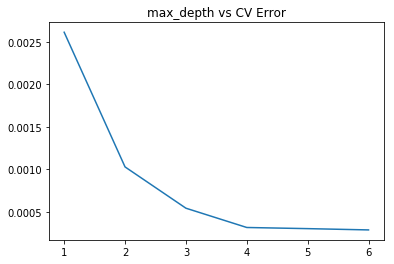

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

In [178]:
dtrain = xgb.DMatrix('t_loan_sum.libsvm')

In [179]:
dtrain

In [192]:
train_df.shape,test_df.shape,train_Y.shape,test_Y.shape

((72794, 562), (18198, 561), (72794, 1), (18198, 1))

In [196]:
target='loan_sum'
IDcol = 'uid'
train_df['loan_sum'].value_counts()

0.000000    57403
5.722768     1250
5.292154     1077
4.723017      712
6.153414      635
4.974843      623
4.292651      599
5.153538      531
5.405416      451
3.862595      424
5.974677      370
5.584137      341
5.501180      340
6.405333      339
5.657311      334
5.781982      327
5.836041      326
5.931813      287
5.885770      271
4.544373      251
6.014775      241
6.292055      198
6.584075      198
4.861602      183
6.087953      141
6.052441      137
5.070593      135
6.722719      133
6.212631      128
5.226704      126
            ...  
6.779674        1
6.301917        1
6.335252        1
6.156513        1
6.970488        1
7.022462        1
7.245607        1
6.713959        1
7.404902        1
6.653100        1
7.005353        1
6.565150        1
6.468305        1
7.670901        1
6.437616        1
6.716474        1
6.790909        1
7.108967        1
6.429702        1
6.369088        1
6.550568        1
7.516524        1
6.757749        1
6.532268        1
6.705073  

In [40]:
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb

In [57]:
dtrain = xgb.DMatrix('build_train_set.libsvm')
dtest = xgb.DMatrix('build_test_set.libsvm')

In [58]:
# specify parameters via map, definition are same as c++ version
param = {'max_depth':4, 'eta':0.3, 'silent':0, 'objective':'binary:logistic'}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'loan_sum')]
num_round = 5
bst = xgb.train(param, dtrain, num_round, watchlist)

XGBoostError: b'[17:34:10] src/objective/regression_obj.cc:158: Check failed: Loss::CheckLabel(y) label must be in [0,1] for logistic regression\n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000018d2027d9 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x000000018da11f80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'

In [214]:
preds = bst.predict(dtest)
labels = dtest.get_label()
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) / float(len(preds))))
bst.save_model('0001.model')

error=0.006207


In [216]:
labels

array([ 0.,  1.,  0., ...,  1.,  0.,  1.], dtype=float32)